# Rehearse Right: A Real-Time AI-Based Emotion Recognition and Feedback for Public Speaking Training Capstone Project.

## Part 1: Facial Emotion Detection using **FER (Facial Expression Recognition)** Challenge Dataset

### Step 1: Getting dataset from Kaggle

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/facial-expression-recognitionferchallenge/Submission.csv
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/README
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.bib
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv


### Step 2: Importing required libraries

In [2]:
import math
import scikitplot
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

Using TensorFlow backend.


### Step 3: Data Acquisition

In [3]:
# Loading the dataset and previewing its structure
data = pd.read_csv('../input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv')
print(data.shape)
data.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


### Step 4: Data Analysis and Preparation

In [4]:
# Checking for unique emotion labels in the dataset
unique_emotions = data['emotion'].unique()
unique_emotions

array([0, 2, 4, 6, 3, 5, 1])

In [5]:
# Mapping emotion labels to text descriptions
emotion_label_to_text = {
    0: 'anger', 
    1: 'disgust', 
    2: 'fear', 
    3: 'happiness', 
    4: 'sadness', 
    5: 'surprise', 
    6: 'neutral'
}

In [6]:
# Counting occurrences of each emotion in the dataset
emotion_counts = data['emotion'].value_counts()
emotion_counts

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

### Step 5: Data Visualization 

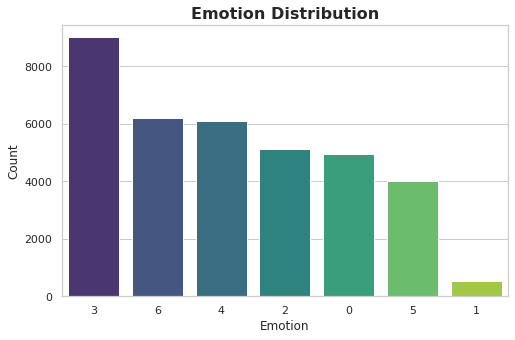

In [7]:
# Visualizing the emotion distribution using a count plot
sns.set(style="whitegrid")  # Setting the style for the plot
pyplot.figure(figsize=(8, 5))  # Setting the figure size

# Creating a count plot with vibrant colors
sns.countplot(
    x='emotion', 
    data=data, 
    palette='viridis', 
    order=data['emotion'].value_counts().index
)

# Adding titles and labels for clarity
pyplot.title('Emotion Distribution', fontsize=16, fontweight='bold')
pyplot.xlabel('Emotion', fontsize=12)
pyplot.ylabel('Count', fontsize=12)

# Displaying the plot
pyplot.show()

The majority of the dataset's classes are represented by the labels 3 (Happy), 4 (Sad), and 6 (Neutral). Our primary focus is also on these three classes.

In [8]:
# Calculating the image size by determining the square root of the first pixel data length
image_size = int(np.sqrt(len(data['pixels'][0].split(' '))))
image_size

48

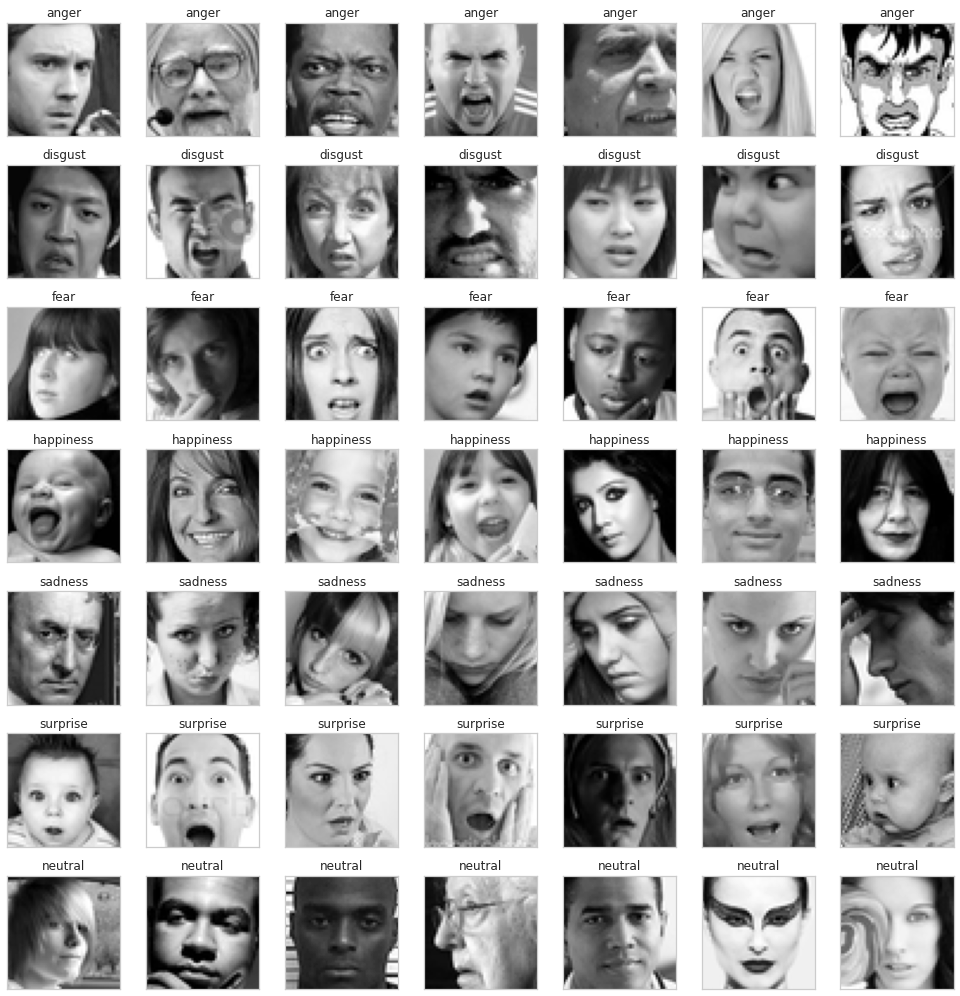

In [9]:
# Displaying sample images for each emotion
fig = pyplot.figure(1, (14, 14))
counter = 0
for emotion in sorted(unique_emotions):
    for sample_index in range(7):  # Looping through a few samples for each emotion
        # Extracting and reshaping pixel data
        pixels = data[data['emotion'] == emotion].iloc[counter]['pixels']
        pixels_array = np.array(pixels.split(' ')).reshape(48, 48).astype('float32')
        
        # Plotting the image
        counter += 1
        ax = pyplot.subplot(7, 7, counter)
        ax.imshow(pixels_array, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[emotion])
        pyplot.tight_layout()

### Step 6: Data Preparation for Training

In [11]:
# Filtering the dataset to include only specific emotions
selected_emotions = [3, 4, 6]  # Focusing on happiness, sadness, and neutral
filtered_data = data[data['emotion'].isin(selected_emotions)]
print(filtered_data.shape)

(21264, 3)


In [12]:
# Converting pixel strings into structured image arrays
img_array = filtered_data['pixels'].apply(
    lambda pixel_string: np.array(pixel_string.split(' ')).reshape(48, 48, 1).astype('float32')
)
# Stacking the arrays into a single numpy array
img_array = np.stack(img_array, axis=0)
print(img_array.shape)

(21264, 48, 48, 1)


In [13]:
# Encoding emotion labels into one-hot vectors
label_encoder = LabelEncoder()
img_labels = label_encoder.fit_transform(filtered_data['emotion'])
img_labels = np_utils.to_categorical(img_labels)
print(img_labels.shape)

(21264, 3)


In [14]:
# Creating a mapping of original labels to their encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)

{3: 0, 4: 1, 6: 2}


### Step 7: Splitting data into Train, Test and Validation Sets

In [15]:
# Splitting the dataset into training and validation sets while maintaining label distribution
X_train, X_valid, y_train, y_valid = train_test_split(
    img_array, img_labels,
    test_size=0.1, random_state=42,
    shuffle=True, stratify=img_labels
)
print("X_Train Shape: ", X_train.shape) 
print("X_Valid Shape: ", X_valid.shape) 
print("Y_Train Shape: ", y_train.shape)
print("Y_Valid Shape: ", y_valid.shape)

X_Train Shape:  (19137, 48, 48, 1)
X_Valid Shape:  (2127, 48, 48, 1)
Y_Train Shape:  (19137, 3)
Y_Valid Shape:  (2127, 3)


In [16]:
# Cleaning up memory by removing unnecessary variables
del data
del img_array
del img_labels

In [17]:
# Extracting image dimensions and class count
img_width, img_height, img_depth = X_train.shape[1], X_train.shape[2], X_train.shape[3]
num_classes = y_train.shape[1]

In [18]:
# Normalizing pixel values to range [0, 1] for better training performance
X_train = X_train.astype('float32') / 255.0
X_valid = X_valid.astype('float32') / 255.0

In [19]:
# Defining a function to build the deep convolutional neural network (DCNN)
def create_model(optimizer_choice):
    """
    Creating a deep convolutional neural network (DCNN) with dropout layers for regularization.
    Using ELU activation to mitigate the dying ReLU issue and he_normal kernel initializer for efficient convergence.
    BatchNormalization layers are added to stabilize and speed up training.
    """
    model = Sequential(name="EmotionRecognitionModel")

    # Adding initial convolutional block
    model.add(Conv2D(64, (5, 5), activation='elu', kernel_initializer='he_normal',
                     padding='same', input_shape=(img_width, img_height, img_depth), name="conv1"))
    model.add(BatchNormalization(name="batchnorm1"))
    model.add(Conv2D(64, (5, 5), activation='elu', kernel_initializer='he_normal', padding='same', name="conv2"))
    model.add(BatchNormalization(name="batchnorm2"))
    model.add(MaxPooling2D(pool_size=(2, 2), name="pool1"))
    model.add(Dropout(0.4, name="dropout1"))

    # Adding middle convolutional block
    model.add(Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same', name="conv3"))
    model.add(BatchNormalization(name="batchnorm3"))
    model.add(Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same', name="conv4"))
    model.add(BatchNormalization(name="batchnorm4"))
    model.add(MaxPooling2D(pool_size=(2, 2), name="pool2"))
    model.add(Dropout(0.4, name="dropout2"))

    # Adding deeper convolutional block
    model.add(Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same', name="conv5"))
    model.add(BatchNormalization(name="batchnorm5"))
    model.add(Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same', name="conv6"))
    model.add(BatchNormalization(name="batchnorm6"))
    model.add(MaxPooling2D(pool_size=(2, 2), name="pool3"))
    model.add(Dropout(0.5, name="dropout3"))

    # Flattening and adding dense layers for final predictions
    model.add(Flatten(name="flatten"))
    model.add(Dense(128, activation='elu', kernel_initializer='he_normal', name="dense1"))
    model.add(BatchNormalization(name="batchnorm7"))
    model.add(Dropout(0.6, name="dropout4"))
    model.add(Dense(num_classes, activation='softmax', name="output"))

    # Compiling the model with selected optimizer
    model.compile(optimizer=optimizer_choice, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [20]:
# Setting up callbacks to prevent overfitting and adjust learning rates dynamically
early_stop = EarlyStopping(
    monitor='val_accuracy', patience=11, min_delta=1e-4,
    restore_best_weights=True, verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.5, patience=7, min_lr=1e-7, verbose=1
)
callback_list = [early_stop, reduce_lr]

In [21]:
# Augmenting data to increase variability in training
data_generator = ImageDataGenerator(
    rotation_range=15, width_shift_range=0.15,
    height_shift_range=0.15, shear_range=0.15,
    zoom_range=0.15, horizontal_flip=True
)
data_generator.fit(X_train)

In [22]:
# Defining batch size, number of epochs, and optimizer choices
batch_size = 32
epochs = 100
optimizer_options = [
    optimizers.Nadam(learning_rate=0.001),
    optimizers.Adam(learning_rate=0.001)
]

In [23]:
# Building and training the model
emotion_model = create_model(optimizer_options[0])

Model: "EmotionRecognitionModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 48, 48, 64)        1664      
_________________________________________________________________
batchnorm1 (BatchNormalizati (None, 48, 48, 64)        256       
_________________________________________________________________
conv2 (Conv2D)               (None, 48, 48, 64)        102464    
_________________________________________________________________
batchnorm2 (BatchNormalizati (None, 48, 48, 64)        256       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 24, 24, 64)        0         
_________________________________________________________________
dropout1 (Dropout)           (None, 24, 24, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 24, 24,

### Step 8: Modal Training and Evaluation

In [24]:
history = emotion_model.fit(
    data_generator.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    epochs=epochs, steps_per_epoch=len(X_train) // batch_size,
    callbacks=callback_list, use_multiprocessing=True
)

Train for 598 steps, validate on 2127 samples
Epoch 1/100
598/598 [==============================] - 15s 24ms/step - loss: 1.3328 - accuracy: 0.4077 - val_loss: 0.9918 - val_accuracy: 0.5007
Epoch 2/100
598/598 [==============================] - 11s 18ms/step - loss: 1.0049 - accuracy: 0.4965 - val_loss: 0.8796 - val_accuracy: 0.5759
Epoch 3/100
598/598 [==============================] - 11s 18ms/step - loss: 0.8931 - accuracy: 0.5681 - val_loss: 0.8138 - val_accuracy: 0.6300
Epoch 4/100
598/598 [==============================] - 10s 17ms/step - loss: 0.8024 - accuracy: 0.6222 - val_loss: 0.7003 - val_accuracy: 0.6859
Epoch 5/100
598/598 [==============================] - 11s 18ms/step - loss: 0.7450 - accuracy: 0.6590 - val_loss: 0.6790 - val_accuracy: 0.7109
Epoch 6/100
598/598 [==============================] - 11s 18ms/step - loss: 0.7091 - accuracy: 0.6797 - val_loss: 0.6308 - val_accuracy: 0.7381
Epoch 7/100
598/598 [==============================] - 11s 18ms/step - loss: 0.6830 

In [25]:
# Saving the model architecture and weights
with open("emotion_model.yaml", "w") as yaml_file:
    yaml_file.write(emotion_model.to_yaml())
emotion_model.save("emotion_model.h5")

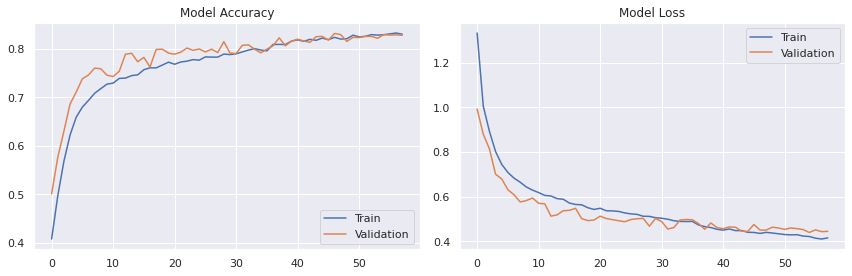

In [26]:
# Plotting training history for accuracy and loss
sns.set()
fig, axes = pyplot.subplots(1, 2, figsize=(12, 4))
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='Train', ax=axes[0])
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='Validation', ax=axes[0])
axes[0].set_title('Model Accuracy')
sns.lineplot(x=history.epoch, y=history.history['loss'], label='Train', ax=axes[1])
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='Validation', ax=axes[1])
axes[1].set_title('Model Loss')
pyplot.tight_layout()
pyplot.savefig("training_history.png")
pyplot.show()

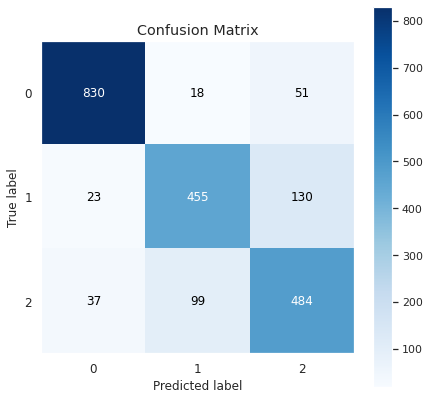

In [27]:
# Plotting confusion matrix
y_pred = np.argmax(emotion_model.predict(X_valid), axis=1)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), y_pred, figsize=(7, 7))
pyplot.savefig("confusion_matrix.png")

In [28]:
# Analyzing validation results with sample predictions
emotion_map = {0: "happy", 1: "sad", 2: "neutral"}
random_indices = np.random.choice(np.arange(X_valid.shape[0]), size=9, replace=False)

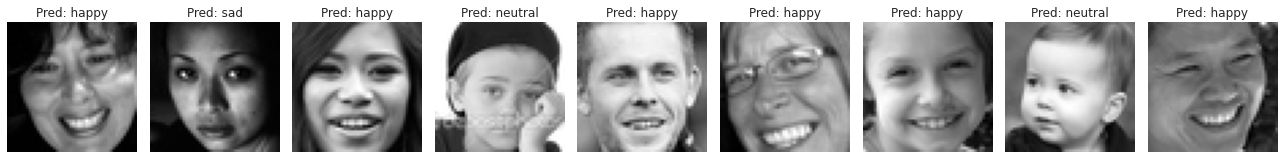

In [29]:
fig = pyplot.figure(figsize=(18, 4))
for idx, rand_idx in enumerate(random_indices):
    ax = pyplot.subplot(1, 9, idx + 1)
    img = X_valid[rand_idx].reshape(48, 48)
    pred = emotion_model.predict_classes(img.reshape(1, 48, 48, 1))[0]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Pred: {emotion_map[pred]}")
    ax.axis('off')
pyplot.tight_layout()
pyplot.savefig("validation_samples.png")